v1 too slow, add for-loop in v2

In [2]:
from ont_fast5_api.fast5_interface import get_fast5_file
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from uncalled4 import PoreModel, Config, EventDetector, SignalProcessor
import numpy as np
import pandas as pd

import sys
import os
from pathlib import Path
current_dir = Path(os.getcwd())
parent_dir = current_dir.parent
code_dir = parent_dir / "code"
sys.path.append(str(code_dir))

import sequence_to_signal
import cam_search_np
from cam_array_np import CAMArray
from event_processor import EventProcessor, fast5_id_list
from cam_process_np import process_sample
from cam_process_np import update_position
from cam_process_np import process_location
from openpyxl import load_workbook
import argparse
from pafstats import run, calculate

Transfer nucleotide sequence to analog signal according to kmer model

In [3]:
# Read the main sequence
main_sequence_path = '../dataset/sarscov2.fna'
main_sequences = sequence_to_signal.read_fasta(main_sequence_path)
main_sequence_length = sequence_to_signal.get_sequence_length(main_sequence_path)

# Read the complement sequence
complement_sequence_path = '../dataset/sarscov2_complement_true.fna'
complement_sequences = sequence_to_signal.read_fasta(complement_sequence_path)
complement_sequence_length = sequence_to_signal.get_sequence_length(complement_sequence_path)

# print(f"Length of main sequence: {main_sequence_length}")
# print(f"Length of complement sequence: {complement_sequence_length}")

# Define the model file path
model_file_path = "../dataset/kmer_model/template_median68pA.model" #r94
df = sequence_to_signal.load_data(model_file_path)

# Retrieve k-mer means and standard deviations for the original reference sequence
kmer_means_raw = sequence_to_signal.get_kmer_properties(main_sequences, df)
kmer_means = sequence_to_signal.replace_continuous_signal(kmer_means_raw)

# Retrieve k-mer means and standard deviations for the complement reference sequence
kmer_means_comp_raw = sequence_to_signal.get_kmer_properties(complement_sequences, df)
kmer_means_comp = sequence_to_signal.replace_continuous_signal(kmer_means_comp_raw)


# print(f"K-mer means for the original sequence: {kmer_means}, Standard deviation: {kmer_std}")
# print(f"K-mer means for the complement sequence: {kmer_means_comp}, Standard deviation: {kmer_std_comp}")
zero_count = sequence_to_signal.count_zeros(kmer_means_comp)
print("Number of zeros in the list:", zero_count)

Processing:   0%|          | 0/29898 [00:00<?, ?iteration/s]

Processing: 100%|██████████| 29898/29898 [00:00<00:00, 406338.36iteration/s]

Number of zeros in the list: 28


Load Random RRAM array

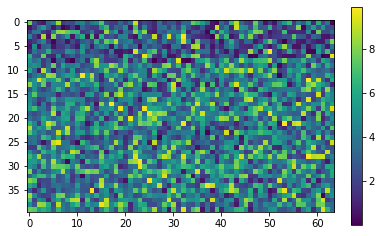

In [4]:
loaded_conductance = np.load('../code/random_conductance/raw_conductance_simulation.npy')
fig, ax = plt.subplots()
cax = ax.imshow(loaded_conductance*1e6, cmap='viridis')  # 显示图像
cbar = fig.colorbar(cax, ax=ax, fraction=0.033, pad=0.05)
plt.show()

flat_list = loaded_conductance.flatten().tolist()
template= flat_list[0:2560]
difference_list_raw = [template[i] - template[i + 1] for i in range(0, len(template) - 1, 2)]

random_conductance = np.array(difference_list_raw).reshape(10, 128)
random_matrix_np = np.asarray(random_conductance).astype(np.float32, copy=False)

# fig, ax = plt.subplots()
# cax = ax.imshow(random_conductance*1e6, cmap='viridis')
# cbar = fig.colorbar(cax, ax=ax, fraction=0.033, pad=0.05)
# plt.show()


Use Random RRAM array to map the analog vector to binary vector; Store the binary vector in CAM Array

In [5]:
col = 10
LSH_col = 128
k = 10
sub_array_row = 400

cam_processor = CAMArray(col=10, LSH_col=128, k=10, sub_array_row=400,
                             kmer_level_means_shift=kmer_means,
                             kmer_level_means_shift_comp=kmer_means_comp, random_matrix=random_conductance, device='cpu')
cam_processor.initialize_matrices()
ref_array_np, ref_array_comp_np = cam_processor.process_LSH()
cam_processor.print_shapes()

# Calculate number of blocks(sub_array)
n_blocks = cam_processor.calculate_sub_arrays(ref_array_np)
print(f"Number of complete blocks: {n_blocks}")

def split_into_submatrices(matrix, row_split_size):
    # Calculate the total number of submatrices
    num_submatrices = matrix.shape[0] // row_split_size

    # Split the matrix into submatrices
    submatrices = [matrix[i * row_split_size:(i + 1) * row_split_size, :] for i in range(num_submatrices)]

    # If there are remaining rows that do not fit into a full submatrix, add them as a final submatrix
    if matrix.shape[0] % row_split_size != 0:
        submatrices.append(matrix[num_submatrices * row_split_size:, :])

    return submatrices
sub_reference_array = split_into_submatrices(ref_array_np, sub_array_row)
sub_reference_array_comp = split_into_submatrices(ref_array_comp_np, sub_array_row)
print(sub_reference_array[50])

Reference Array Shape: (29888, 10)
Reference Comp Array Shape: (29888, 10)
Number of complete blocks: 74
[[0 0 1 ... 1 0 0]
 [0 0 0 ... 0 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 0 1 ... 1 1 0]
 [1 1 0 ... 0 1 0]
 [1 1 1 ... 0 1 0]]


generate events

In [6]:
# Two parameter for event
sp, sp1 = EventProcessor()
#read read_id from list samples here
fast5_file = "../dataset/SP1-mapped500.fast5"   
read_id = fast5_id_list(fast5_file)

In [7]:
position = []
direction = []
search_time = []
vote_location = []


# three parameter for process
difference = [3, 3.5, 4]
sample_number = 4000
_Threshold = 7
Threshold = _Threshold
read_number = 1000


# for i in tqdm(range(73,74)):
for i in tqdm(range(0,read_number)):
    _read_id = read_id[i]
    final_location, dir, _search_time, _votes = process_sample(sample_number, sp, _read_id, fast5_file, random_matrix_np, sub_reference_array, sub_reference_array_comp, col, Threshold, sub_array_row, n_blocks, difference)
    
    position.append(final_location)
    direction.append(dir)
    search_time.append(_search_time)
    vote_location.append(_votes)

100%|██████████| 1000/1000 [1:31:27<00:00,  5.49s/it]


In [8]:
print(position)
print(direction)
print(search_time)
print(vote_location)
N_count = sum(1 for item in position if item == 'N')
print(N_count)

[24, 43, 39, 'N', 15, 30, 41, 'N', 62, 54, 14, 'N', 52, 'N', 33, 45, 65, 62, 12, 2, 2, 23, 51, 28, 16, 73, 56, 42, 30, 62, 46, 2, 'N', 57, 56, 47, 54, 62, 45, 45, 35, 66, 43, 30, 73, 56, 35, 69, 16, 26, 43, 2, 'N', 54, 35, 47, 'N', 'N', 14, 45, 27, 68, 'N', 7, 'N', 66, 33, 22, 51, 23, 2, 'N', 33, 17, 32, 32, 16, 14, 70, 35, 7, 'N', 8, 22, 7, 'N', 42, 55, 29, 29, 31, 22, 30, 22, 31, 8, 46, 45, 30, 54, 30, 30, 41, 'N', 28, 39, 46, 54, 37, 2, 27, 'N', 16, 28, 57, 35, 29, 31, 30, 'N', 'N', 30, 15, 25, 34, 72, 'N', 62, 4, 35, 35, 63, 73, 43, 15, 36, 56, 20, 46, 62, 43, 29, 35, 28, 'N', 32, 2, 63, 'N', 6, 47, 35, 8, 'N', 17, 'N', 43, 35, 33, 'N', 43, 9, 'N', 55, 35, 12, 35, 52, 25, 'N', 35, 57, 27, 39, 26, 25, 43, 27, 56, 17, 65, 42, 42, 70, 16, 20, 66, 29, 52, 'N', 54, 33, 29, 35, 73, 14, 35, 61, 'N', 38, 2, 54, 70, 17, 56, 33, 40, 23, 16, 46, 46, 15, 2, 'N', 14, 54, 22, 32, 47, 46, 16, 35, 22, 59, 32, 35, 62, 53, 50, 38, 62, 'N', 35, 57, 65, 17, 34, 47, 'N', 29, 27, 8, 45, 43, 33, 45, 45, 

In [9]:
index = [i for i, x in enumerate(position) if x == 'N']
update_position(sample_number, position, direction, search_time, vote_location, sp1, read_id, fast5_file, index, [4, 3], random_matrix_np, sub_reference_array, sub_reference_array_comp, col, Threshold, sub_array_row, n_blocks)

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [07:43<00:00,  5.15s/it]


In [10]:
print(position)
print(direction)
print(search_time)
print(vote_location)
N_count = sum(1 for item in position if item == 'N')
print(N_count)

[24, 43, 39, 'N', 15, 30, 41, 'N', 62, 54, 14, 46, 52, 'N', 33, 45, 65, 62, 12, 2, 2, 23, 51, 28, 16, 73, 56, 42, 30, 62, 46, 2, 63, 57, 56, 47, 54, 62, 45, 45, 35, 66, 43, 30, 73, 56, 35, 69, 16, 26, 43, 2, 28, 54, 35, 47, 'N', 67, 14, 45, 27, 68, 'N', 7, 16, 66, 33, 22, 51, 23, 2, 'N', 33, 17, 32, 32, 16, 14, 70, 35, 7, 54, 8, 22, 7, 70, 42, 55, 29, 29, 31, 22, 30, 22, 31, 8, 46, 45, 30, 54, 30, 30, 41, 'N', 28, 39, 46, 54, 37, 2, 27, 17, 16, 28, 57, 35, 29, 31, 30, 8, 38, 30, 15, 25, 34, 72, 'N', 62, 4, 35, 35, 63, 73, 43, 15, 36, 56, 20, 46, 62, 43, 29, 35, 28, 14, 32, 2, 63, 'N', 6, 47, 35, 8, 38, 17, 6, 43, 35, 33, 2, 43, 9, 16, 55, 35, 12, 35, 52, 25, 'N', 35, 57, 27, 39, 26, 25, 43, 27, 56, 17, 65, 42, 42, 70, 16, 20, 66, 29, 52, 17, 54, 33, 29, 35, 73, 14, 35, 61, 'N', 38, 2, 54, 70, 17, 56, 33, 40, 23, 16, 46, 46, 15, 2, 'N', 14, 54, 22, 32, 47, 46, 16, 35, 22, 59, 32, 35, 62, 53, 50, 38, 62, 42, 35, 57, 65, 17, 34, 47, 45, 29, 27, 8, 45, 43, 33, 45, 45, 33, 54, 2, 35, 12, 3,

In [11]:
_position=position
_direction=direction
_direction = ['*' if x == 'N' else x for x in _direction]

low_boundary=[]
high_boundary=[]
_position=np.array(_position)
low_boundary,high_boundary= process_location(sample_number, sp, low_boundary, high_boundary, read_id, read_number, _position, fast5_file, sub_array_row)

print(low_boundary)
print(high_boundary)
print(_direction)



[8400, 15976, 14400, '*', 4764, 10773, 15116, '*', 23600, 20400, 4286, 17200, 19600, '*', 12000, 16800, 24800, 23600, 3600, 400, 388, 7979, 19200, 9937, 5200, 28000, 21200, 15600, 10800, 23600, 17200, 375, 23988, 21555, 21161, 17561, 20400, 23600, 16734, 16800, 12791, 25155, 15997, 10800, 28000, 21200, 12797, 26400, 5152, 9200, 15955, 400, 9898, 20400, 12800, 17534, '*', 25567, 4307, 16800, 9585, 26000, '*', 1600, 5200, 25200, 12000, 7600, 19200, 8000, 400, '*', 12000, 5600, 11600, 11477, 5152, 4385, 26800, 12800, 1594, 20400, 1979, 7540, 1600, 26800, 15561, 20800, 10400, 10400, 11200, 7600, 10800, 7600, 11200, 2000, 17200, 16755, 10800, 20400, 10800, 10794, 15152, '*', 9967, 14337, 17146, 20400, 13600, 400, 9591, 5600, 5167, 10000, 21600, 12767, 10307, 11200, 10800, 2000, 14000, 10737, 4800, 8779, 12400, 27600, '*', 23600, 376, 12800, 12776, 23973, 28000, 15898, 4800, 13200, 21200, 6740, 17194, 23597, 16000, 10400, 12800, 9973, 4370, 11501, 400, 23991, '*', 1200, 17600, 12800, 1922, 1

In [12]:
data_list = _direction

template_file_path = '../code/result_template/test_SP1_500_template.xlsx'
# template_file_path = 'result_template/test_LSH_v2.xlsx'

wb = load_workbook(template_file_path)
ws = wb.active  

for index, item in enumerate(data_list, start=1):  
    ws[f'E{index}'].value = item

for index, item in enumerate(low_boundary, start=1):  
    ws[f'H{index}'].value = item

for index, item in enumerate(high_boundary, start=1):  
    ws[f'I{index}'].value = item

output_file_path = "../code/result/debug_{}_test_LSH_rm_threshold_{}.xlsx".format(sample_number, _Threshold)

wb.save(output_file_path)

output_file_path_txt = "../code/result/debug_{}_test_LSH_rm_threshold_{}".format(sample_number, _Threshold)

with open(output_file_path_txt, 'w', encoding='utf-8') as f:
    for row in ws.iter_rows(values_only=True):
        row_data = '\t'.join(map(str, row))
        f.write(row_data + '\n')

In [13]:
# import argparse
# from pafstats import run
args = argparse.Namespace(
    infile=output_file_path_txt,  
    max_reads=read_number,  
    ref_paf="../code/result_template/minimap2_sars2.paf",
    annotate=False
)

run(args)

Summary: 1000 reads, 956 mapped (95.60%)

Comparing to reference PAF
     P     N
T  94.80  0.00
F   0.80  4.40
NA: 0.00

Recall: 95.56

Precision: 99.16

F1: 97.33

